# Part 1: Solving a wave problem with sparse matrices

To ease documentation, I will number the following equations from the assignment. $\mathrm{A}$ is a known matrix, $\mathbf{f}$ is a known vector, and $\mathbf{u}$ is an unknown vector that we want to compute.

The entries of $\mathbf{f}$ are given by

$$
f_i = \begin{cases}
1&\text{if }i=N,\\
0&\text{otherwise}.
\end{cases} \tag{C1}
$$

The entries of $\mathrm{A}$ are given by

$$
A_{i,j} = 
\begin{cases}
1&\text{if }i=j,\\
0&\text{otherwise},
\end{cases} \tag{C2}
$$
if $i=0$ or $i=N$; and

$$
A_{i, j} = 
\begin{cases}
2-h^2k^2&\text{if }j=i,\\
-1&\text{if }j=i+1,\\
-1&\text{if }j=i-1.\\
0&\text{otherwise},
\end{cases} \tag{C3}
$$
otherwise.

In [1]:
import numpy as np
from scipy.sparse import coo_matrix, linalg

def wave_equation(N):
  """Returns A, f in the equation Au = f in the finite-difference approximation
  with $N+1$ points to the wave equation $d^2 u/dx^2 + (29\pi/2)^2 u = 0$ in
  $x = (0,1)$; $u = 0$ at $x = 0$; $u = 1$ at $x = 1$."""
  k = 29*np.pi/2
  h = 1/N
  # use COO format for matrix A, which requires initialising row, col, and data
  # arrays. f is a numpy vector.
  rows = []
  cols = []
  data = []
  f = np.zeros(N+1)

  for i in range(N+1):
    # Condition (C1)
    if i == N:
      f[i] = 1.

    for j in range(N+1):
      # Condition (C2)
      if i == 0 or i == N:
        if i == j:
          rows += [i]
          cols += [j]
          data += [1.]
      else:
        # Condition (C3)
        if j == i:
          rows += [i]
          cols += [j]
          data += [2 - h**2 * k**2]
        if j == i + 1 or j == i - 1:
          rows += [i]
          cols += [j]
          data += [-1.]
  rows = np.array(rows)
  cols = np.array(cols)
  data = np.array(data)
  A = coo_matrix((data, (rows, cols)), (N+1, N+1))
  return A, f

# store solutions of u for different N in an array, and create an array for the
# x-coordinate
u = []
x = []
for N in [10, 100, 1000]:
  A, f = wave_equation(N)
  u.append(linalg.spsolve(A, f))
  x.append(np.linspace(0, 1, N+1))

C:\Program Files\Anaconda 3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


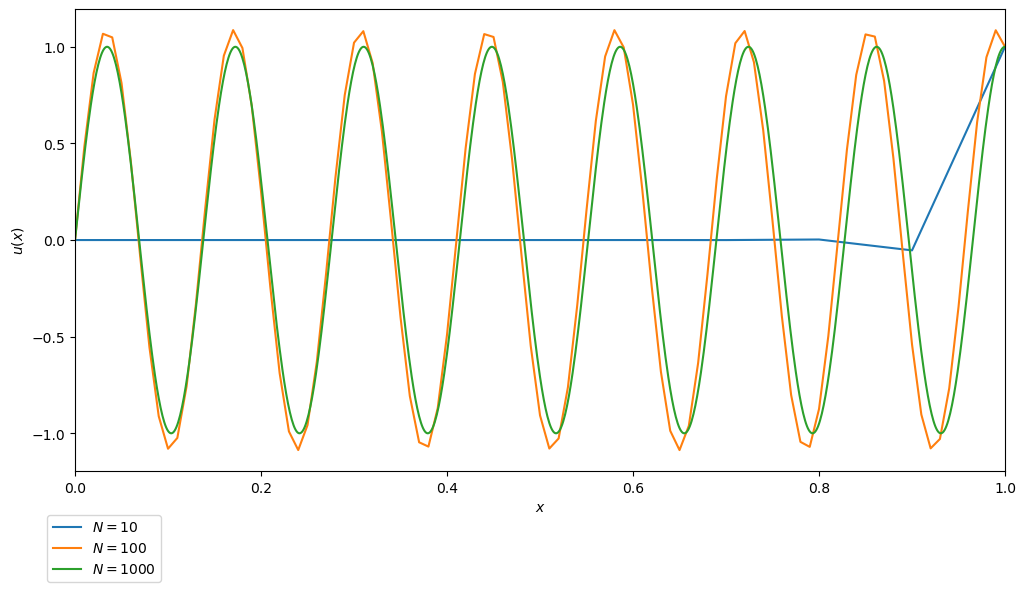

In [2]:
import matplotlib.pyplot as plt

# plot solutions of u
fig = plt.figure(figsize=(12, 6))
plt.plot(x[0], u[0])
plt.plot(x[1], u[1])
plt.plot(x[2], u[2])

# make it look nice
plt.legend([r"$N=10$", r"$N=100$", r"$N=1000$"], bbox_to_anchor=(0.1, -0.08))
plt.xlim([0., 1.])
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.show()

The graphs for $N=100$ and $N=1000$ look rather similar, while the graph for $N=10$ is extremely different from the other two. I expect the graph for $N=1000$ to be closest to the exact solution, as in general the more iterations, the closer you should get to the exact solution (up to a point where the finite machine precision starts to affect things).

In [3]:
from timeit import timeit

def u_exact(N):
  """Returns a vector u with $N$ points which exactly solves the wave
  equation described in wave_equation(N)."""
  return np.sin(29*np.pi/2 * np.linspace(0, 1, N+1))

def solve_equation(N):
  """Solves the wave equation numerically using wave_equation"""
  A, f = wave_equation(N)

n_points = [10, 25, 50, 75, 100, 250, 500, 1000, 2500, 5000, 10000]
error = np.empty(len(n_points))
time_taken = np.empty(len(n_points))

# find the absolute error
for i, N in enumerate(n_points):
  A, f = wave_equation(N)
  u = linalg.spsolve(A, f)
  error[i] = np.max(np.abs(u - u_exact(N)))

# time to compute approximation
for i, N in enumerate(n_points):
  A, f = wave_equation(N)
  # Note: I assume that "measure the time taken to compute your
  # approximation for your function" means the time that scipy takes
  # to solve for u (if it were measuring the time for wave_equation
  # it would be better phrased as "measure the time taken to compute
  # your function and the approximation for your function")  
  t = timeit("linalg.spsolve(A, f)", "from scipy.sparse import coo_matrix, linalg; from __main__ import wave_equation, A, f", number=1)
  time_taken[i] = t

Text(0, 0.5, 'Error')

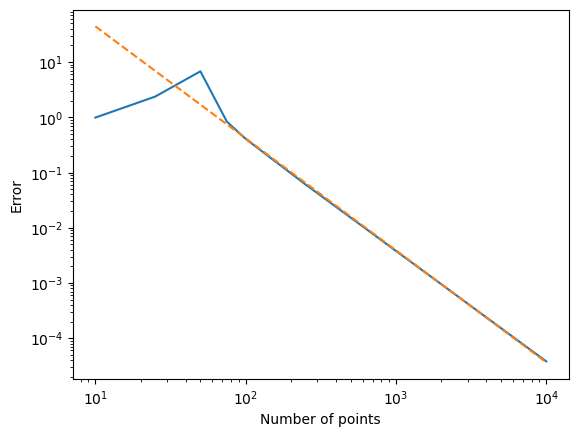

In [4]:
plt.plot(n_points, error)
plt.plot(n_points, 4733*np.array(n_points)**-2.028, '--')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of points")
plt.ylabel("Error")

Text(0, 0.5, 'Time taken')

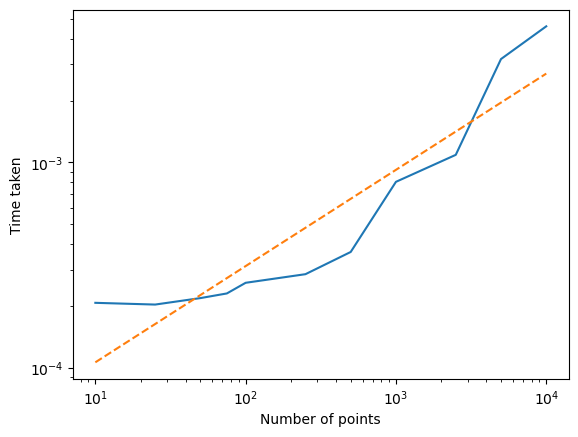

In [5]:
plt.plot(n_points, time_taken)
plt.plot(n_points, 3.63e-5*np.array(n_points)**0.468, '--')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of points")
plt.ylabel("Time taken")

For the two plots given above I have also included regressions of the form $y=aN^b$, given in the dashed line (these values were produced by desmos, as I can't remember how to perform regressions in python). Using these regressions, we can extrapolate to find $N$ that would give the error predicted to be $10^{-8}$ or less:

$$\begin{aligned} \log_{10}(4733) - 2.028\log_{10}N &= -8 \\ N &= 10^{5.757} = 571500\end{aligned}$$

then substitute this into the regression for the time taken:

$$ 3.63\times 10^{-5} \cdot 571500^{0.468} = 0.018 $$

In [6]:
A, f = wave_equation(571500)
u = linalg.spsolve(A, f)
error = np.max(np.abs(u - u_exact(N)))
t = timeit("linalg.spsolve(A, f)", "from scipy.sparse import coo_matrix, linalg; from __main__ import wave_equation, A, f", number=1)

KeyboardInterrupt: 

Unfortunately, the bottleneck is creating the matrix/vector $A$ and $\mathbf{f}$ and not solving the sparse system of equations, as the above expressions are taking longer than 90 minutes (which I expect is more than a reasonable time) to compute. The `KeyboardInterrupt` at the 90 minute mark shows that python is still working on creating the matrix.

It is likely that extrapolation of the error graph will fail for errors less than machine precision. An error of $10^{-8}$ is less than machine precision for single-precision floats ($\varepsilon_\text{rel} \approx 1.2\times 10^{-7}$) but not for double-precision floats, which are the default floats used in numpy and python ($\varepsilon_\text{rel} \approx 2.2\times 10^{-16}$), so I would not expect $10^{-8}$ to be an unachievable error, but it is possible that in the computation of `scipy.sparse.linalg.spsolve` smaller values are used which may cause an error higher than predicted.

# Part 2: Solving the heat equation with GPU acceleration

The strategy for this section is as follows. From the assessment we have $0 \leq i\leq N$ corresponding to $0\leq x \leq 1$ representing the position on the rod, and $0\leq j$ corresponding to $0\leq t$ representing time. Initialise $u_i^j$ as an $(M+1)\times (N+1)$ matrix $u_{j, i}$ where the columns indicate position and the rows indicate time. If the maximum time is $t_\text{final}$, then since $t_j = jh = j/N$, $M = t_\text{final}N$.

Then, we will allocate calculations to the threads each calculating an entry of $u^j$ (ie. a row of $\mathbf{u}$). We store the entire row into shared memory and each thread will calculate a value in the next row $u^{j+1}$. When this is complete, preload the next row into shared memory and repeat.

The reason for using 2D array is because if you create a kernel that only inputs and outputs the next row of $\mathbf{u}$, it is necessary to use a for loop outside the kernel, which means you will have to constantly copy data in and out of the device. This is inefficient.

In [7]:
from numba import cuda

cuda.detect()

# Note that I assume "Implement this iterative scheme in Python" can also be
# done using GPU acceleration, such that this automatically satisfies "Use
# `numba.cuda` to parallelise your implementation on a GPU".

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-ca0412d5-6056-0cf8-67c7-6efa469fd3ea
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [8]:
import numpy as np
import numba

##############################################################################
# GLOBAL INPUTS FOR `heat_equation(u)`
# ------------------------------------
# When creating a shared array `numba.cuda` does not like a parametrized
# array size: see https://stackoverflow.com/questions/73335040/
# So instead I had to define the inputs for `heat_equation` in the global
# scope.
N = 500
t_final = 60
##############################################################################

# derived quantities
h = 1/N
M = t_final * N

# define threads per block, blocks per grid. Since the matrix is N+1 columns
# long you need N+1 threads. TPB also convieniently defines the size of the
# shared array.
TPB = N+1
# if N is too large that it exceeds the maximum TPB (1024), then we can
# increment BPG as well so that TPB*BPG >= N+1. however, the code does not
# support this due to the iterative scheme failing to work for large N (see
# the section below).
BPG = 1

@cuda.jit
def heat_equation(u):
  """GPU-parallelised code to calculate the solution of the heat equation.
  Requires parameter 'u', a M+1 by N+1 matrix* with the first row initialised
  for t=0. 'u' is then calculated in place. Also requires N and t_final to be
  defined in the global scope.
  
  *see comment at beginning of section"""

  # define position number
  x = cuda.grid(1)

  # create shared array with size N+1
  sh = cuda.shared.array(TPB, numba.float32)

  for j in range(M):
    # load shared array
    sh[x] = u[j, x]
        
    cuda.syncthreads()
    # do calculation
    if x == 0:
      u[j+1, x] = numba.float32(10)
    elif x == N:
      u[j+1, x] = numba.float32(10)
    else:
      u[j+1, x] = sh[x] + (sh[x-1] - 2*sh[x] + sh[x+1]) / numba.float32(1000 * h)
    cuda.syncthreads()

# initialise u
u = np.zeros((M+1, N+1))
u[0, 0] = 10
u[0, N] = 10

# send over to device
result = cuda.to_device(u.astype('float32'))

# beep boop blip
heat_equation[BPG, TPB](result)

# retrieve from device
u = result.copy_to_host()

/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


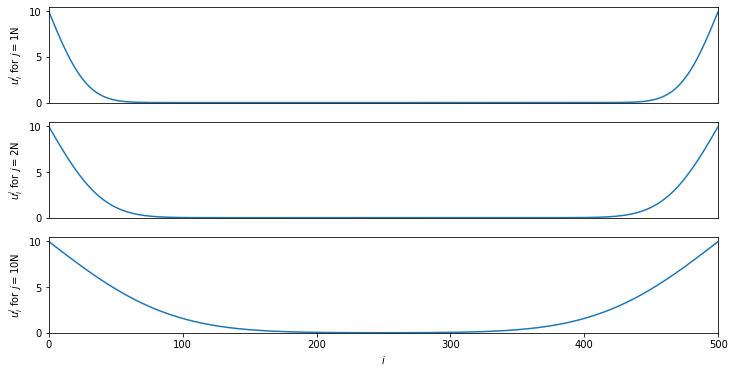

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))

for subplot, time in enumerate([1, 2, 10]):
  ax = fig.add_subplot(3, 1, subplot+1)
  ax.plot(u[time*N, :])
  ax.set_xlim(0, N)
  ax.set_ylim(0)
  ax.set_xlabel(r'$i$')
  ax.set_ylabel(r'$u_i^j$ for $j=$' + str(time) + 'N')
  # do this for all plots except the final plot
  if subplot != 2:
    ax.set_xlabel('')
    ax.set_xticks([])

$N$ was chosen as the lowest value such that the curves plotted above were sufficiently smooth. As a reference, for $N=501$, it appeared that there was a catastrophic loss of significance (from the limited machine precision) causing a very spiky-looking graph (see the picture).

![Plots for N=501](img/spikes.png)

(0.0, 3.0)

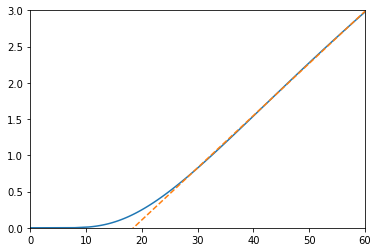

In [10]:
t = np.linspace(0, 60, 60*N+1)

plt.plot(t, u[:, N//2])
plt.plot(t, 0.072*(t-18.5), '--')
plt.xlim([0, 60])
plt.ylim([0, 3])

To estimate the time at which the temperature of the midpoint of the rod first exceeds a temperature of 9.8, I first plotted the iterative scheme up to $t=60$ above. It appeared that the temperature of the midpoint of the rod follows a roughly linear pattern for $30\leq t\leq 60$, so I used a linear line of best fit (orange) with the equation

$$ u(0.5, t) = 0.072(t-18.5).$$

Solving for $u = 9.8$ gives $t=154.61$, but I also expect the temperature to taper off when nearing $u = 10$, so that the linear line of best fit may not be accurate to this degree.